### Fetching DATASETS

In [36]:
import pandas as pd
import numpy as np
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [37]:
numb_batch = 64  # This means that the data will be loaded in batches of 64 samples at a time.

### Getting Data

In [38]:
T = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()   # converts images into PyTorch tensors.
])
# training dataset called "train_data" using the MNIST dataset from the 'mnist_data' directory
train_data = torchvision.datasets.MNIST('mnist_data',train=True , download=True , transform =T)
# validation dataset called "val_data" using the MNIST dataset from the 'mnist_data' directory.
val_data = torchvision.datasets.MNIST('mnist_data',train=False , download=True , transform =T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=numb_batch)

100%|██████████| 9912422/9912422 [00:00<00:00, 11106489.64it/s]


Extracting mnist_data\MNIST\raw\train-images-idx3-ubyte.gz to mnist_data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14448436.76it/s]


Extracting mnist_data\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9938710.41it/s]


Extracting mnist_data\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting mnist_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_data\MNIST\raw



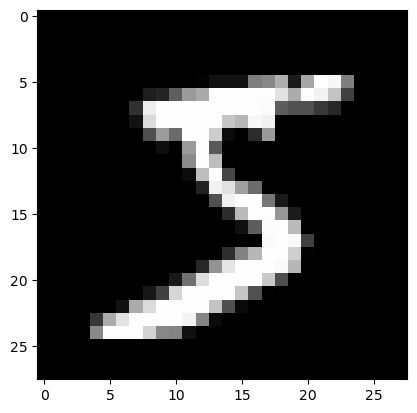

In [50]:
plt.imshow(train_data[0][0][0], cmap="gray")

### Creating Model

In [55]:
def create_detector():
    model=nn.Sequential(
        
        # first convolutional layer
        nn.Conv2d(1,6,5, padding = 2),  #i/p channel =1  o/p channel = 6, kernal size = 5x5 
        # padding of 2 pixels to maintain the spatial dimensions of the feature map
        nn.ReLU(),
        #It reduces the spatial dimensions of the feature map by a factor of 2, reduces complexity
        nn.AvgPool2d(2, stride=2), 
        
        # 2nd convolution layer 
        # input with 6 channels (output from the previous layer) and produces an output with 16 channels. 
        nn.Conv2d(6,16,5, padding = 0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2), # reduces the spatial dimensions of the feature map by a factor of 2
        
        nn.Flatten(), # flattens the 2D feature maps into a 1D vector
        
        nn.Linear(400 , 120),  # first fully connected (linear) layer, flattened input of size 400 (which comes from the previous layer)
        # and produces an output of size 120.
        
        nn.Linear(120, 84), # second fully connected layer
        nn.Linear(84,10)
    
    
    )
    return model

### Model Validation

In [57]:
def validate(model,data):
    total = 0  # keep track of the total number of data points processed
    correct = 0 # keep track of the number of correctly predicted data points.
    for i, (images, labels) in enumerate(data):
        x=model(images)  # x is basicaly the prediction for model
        value, pred = torch.max(x,1) # finds the maximum value and its corresponding index 
        total += x.size(0)
        correct += torch.sum(pred == labels)
    
    return correct*100./total

In [87]:
import copy

### Model Training

In [91]:
def train(num_epoch=5, lr=1e-3):
    accuracies=[] # init empty lists to store accuracy values during training
    cnn = create_detector()  # create an instance of a CNN model.
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)  #pdate the model's parameters during training
    max_accuracy = 0 #initializind accuracy
    
    for epoch in range(num_epoch):
        for i,(images, labels) in enumerate(train_dl):
            #mages = images.to(device)
            #abels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
            
            #calculates the accuracy of the trained CNN model (cnn) on the validation dataset (val_dl)
            #by alling the validate function.
            
        accuracy=float(validate(cnn,val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model=copy.deepcopy(cnn) # This is done to save the model with the highest 
           #accuracy achieved during training.
        
            max_accuracy = accuracy
            print ("Saving best model with accuracy" , accuracy)
        print ("Epoch: " , epoch+1, "ccuracy: ", accuracy,"%")
    plt.plot(accuracies)
    return best_model
                       

Saving best model with accuracy 95.20999908447266
Epoch:  1 ccuracy:  95.20999908447266 %
Saving best model with accuracy 97.19999694824219
Epoch:  2 ccuracy:  97.19999694824219 %
Saving best model with accuracy 97.87000274658203
Epoch:  3 ccuracy:  97.87000274658203 %
Saving best model with accuracy 98.0999984741211
Epoch:  4 ccuracy:  98.0999984741211 %
Saving best model with accuracy 98.22000122070312
Epoch:  5 ccuracy:  98.22000122070312 %
Saving best model with accuracy 98.5199966430664
Epoch:  6 ccuracy:  98.5199966430664 %
Saving best model with accuracy 98.72000122070312
Epoch:  7 ccuracy:  98.72000122070312 %
Saving best model with accuracy 98.80000305175781
Epoch:  8 ccuracy:  98.80000305175781 %
Epoch:  9 ccuracy:  98.68000030517578 %
Epoch:  10 ccuracy:  98.63999938964844 %


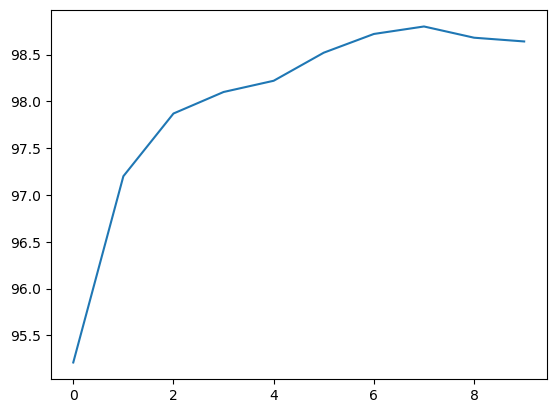

In [92]:
detector = train(10)

In [99]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i , (images, labels) in enumerate (data):
        x= model(images)
        value, pred=torch.max(x,1) # finds the maximum value and its corresponding index
        pred = pred.data
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)
        

In [100]:
# obtain predicted values and true values from a trained machine learning model
# (detector) on a validation dataset

y_pred,y_true = predict_dl(detector, val_dl)

In [107]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [108]:
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [110]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,976,0,1,0,0,1,0,0,1,1
1,0,1133,1,0,0,1,0,0,0,0
2,1,1,1023,1,1,0,1,1,3,0
3,0,0,2,992,0,10,0,3,3,0
4,1,0,1,0,965,0,1,0,0,14
5,2,0,0,1,0,888,1,0,0,0
6,3,2,0,0,0,9,941,0,3,0
7,0,3,13,1,0,0,0,1006,2,3
8,2,0,2,1,0,2,1,2,963,1
9,1,1,0,0,3,5,0,2,4,993


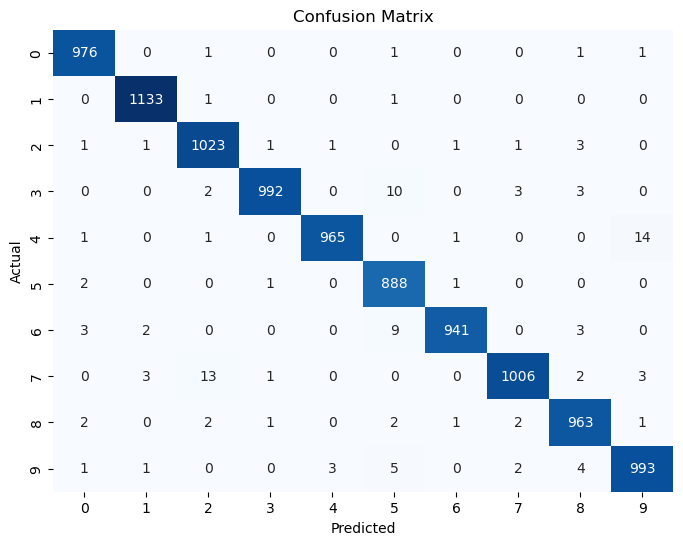

In [131]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(0, 10))

# Create a DataFrame from the confusion matrix
confusion_df = pd.DataFrame(conf_matrix, index=np.arange(0, 10), columns=np.arange(0, 10))

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [133]:
from sklearn.metrics import classification_report
class_labels = [str(label) for label in np.arange(0, 10)]
class_report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       1.00      0.98      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.97      1.00      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [114]:
import requests
from PIL import Image
from io import BytesIO

### Testing The Model

In [115]:
def inference(path, model):
    r = requests.get(path)         # we are using request library to get path of test image
    
    # opens the image content received from the HTTP request as a binary stream using BytesIO. 
    # The image content is stored in the f variable.
    
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))   # we are resizing img to 28x28
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float())
        return F.softmax(pred, dim=-1).cpu().numpy()

In [125]:
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

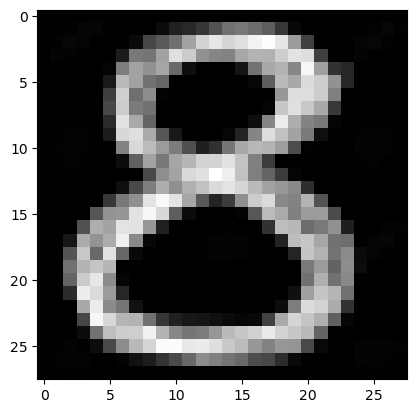

In [126]:
plt.imshow(x.squeeze(-1), cmap="gray")

### Prediction

In [129]:
pred = inference(path, detector)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 50.49455761909485 %


In [130]:
pred

array([[1.00825071e-06, 2.74393557e-07, 6.26917754e-05, 2.02030241e-02,
        1.03248703e-05, 4.68674332e-01, 6.10265788e-03, 1.38723335e-08,
        5.04945576e-01, 3.90690751e-08]], dtype=float32)